In [51]:
import numpy as np
import os
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
from scipy.io.wavfile import read as read_wav
plt.rcParams['axes.grid'] = True

In [125]:
def load_sample(label, sample_number):
    data_dir = r'/home/kolai/Data/speech_commands_v0.01'
    samples_dir = os.path.join(data_dir, label)
    sample_name = os.listdir(samples_dir)[sample_number]
    sample_path = os.path.join(samples_dir, sample_name)
    fs, x = read_wav(sample_path)
    x = (x-x.mean())/x.std()
    x_zero_padded = np.zeros(fs)
    x_zero_padded[:min(fs, len(x))] = x[:fs]
    return x_zero_padded, fs


x, fs = load_sample('cat', 0)
sd.play(x, fs)
print('fs = {}Hz\nx[n] = {}'.format(fs, x))

fs = 16000Hz
x[n] = [ 0.00590766 -0.01606771 -0.02293501 ...  0.00281738  0.00316074
 -0.0033632 ]


Text(0.5,32.0833,'time, s')

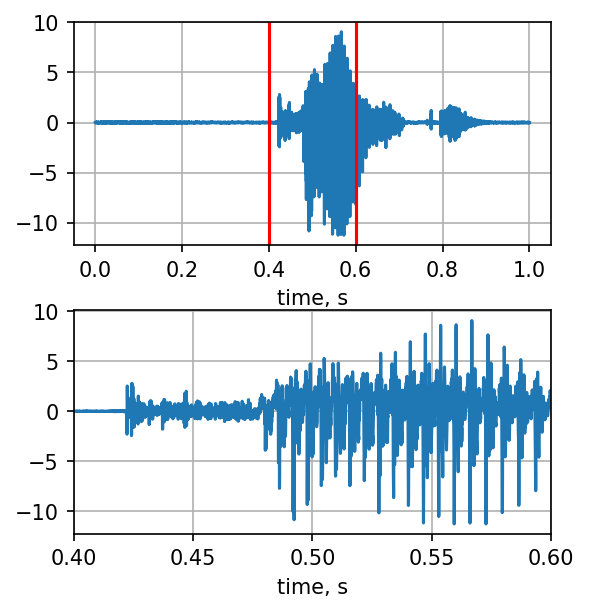

In [126]:

fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
plt.tight_layout()


time = np.arange(len(x))/fs

segment = [0.4, 0.6]
ax[0].plot(time, x)
ax[0].set_xlabel('time, s')
[ax[0].axvline(b, color='r') for b in segment]
ax[1].plot(time, x)
ax[1].set_xlim(segment)
ax[1].set_xlabel('time, s')

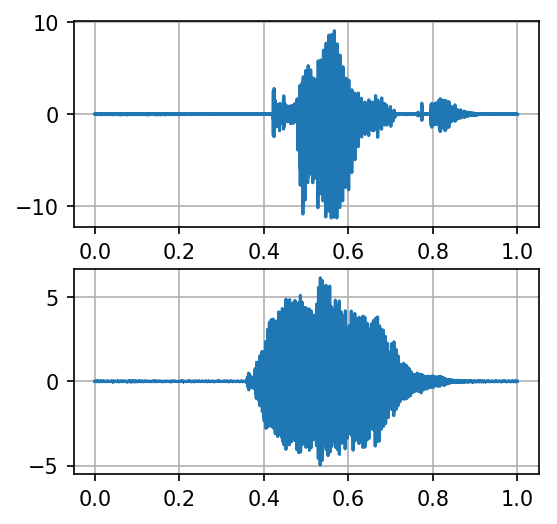

In [127]:
cat, fs = load_sample('cat', 0)
dog, fs = load_sample('dog', 5)

fig, ax = plt.subplots(2, figsize=(4,4), dpi=150)
ax[0].plot(time, cat)
ax[1].plot(time, dog)

Text(0.5,0,'Freq. Hz')

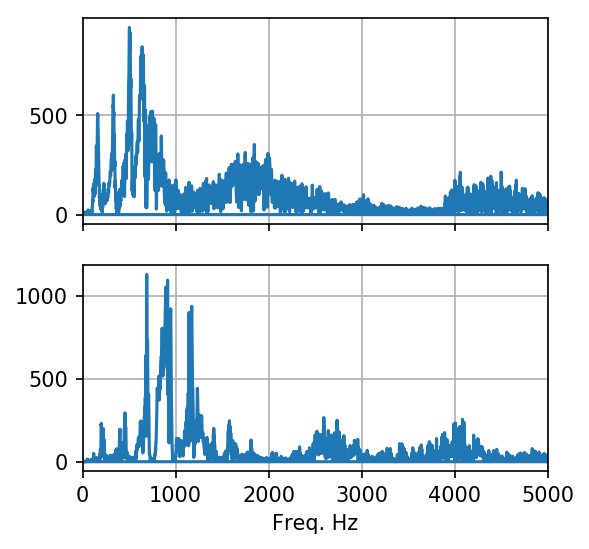

In [128]:
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150, sharex=True)

freq = np.fft.fftfreq(n=fs, d=1/fs)
fft_cat = np.abs(np.fft.fft(cat))
fft_dog = np.abs(np.fft.fft(dog))
ax[0].plot(freq, fft_cat)
ax[1].plot(freq, fft_dog)
ax[1].set_xlim(0, 5000)
ax[1].set_xlabel('Freq. Hz')

Text(0.5,0,'Freq. Hz')

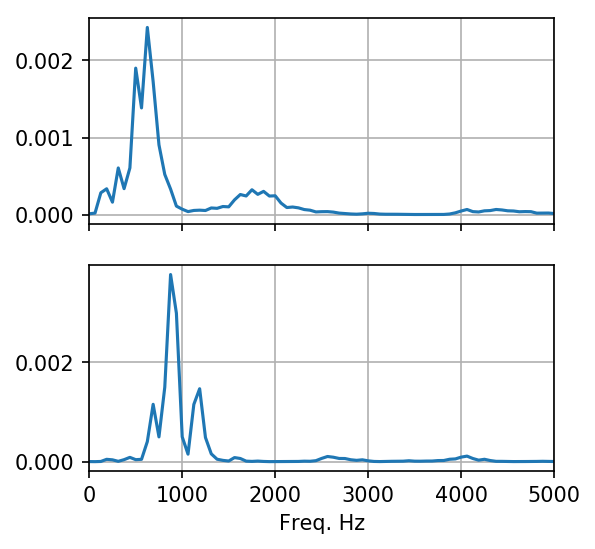

In [129]:
fig, ax = plt.subplots(2, figsize=(4,4), dpi=150, sharex=True)

freq, fft_cat = sg.welch(cat, fs, nperseg=256*1)
freq, fft_dog = sg.welch(dog, fs, nperseg=256*1)
ax[0].plot(freq, fft_cat)
ax[1].plot(freq, fft_dog)
ax[1].set_xlim(0, 5000)
ax[1].set_xlabel('Freq. Hz')

Text(0.5,0,'Freq., Hz')

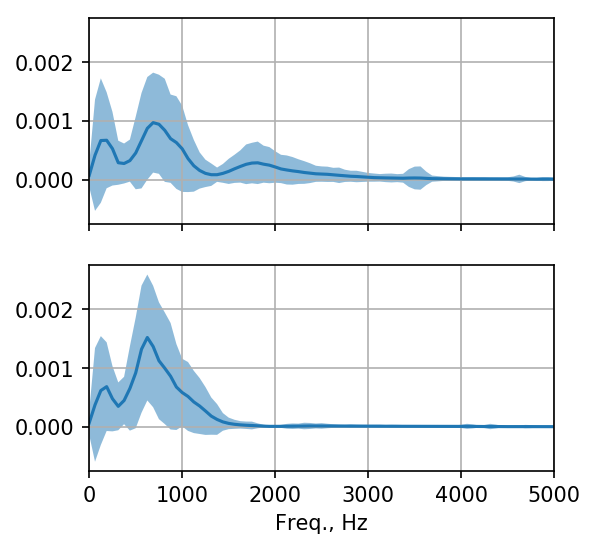

In [296]:
fig, axes = plt.subplots(2, figsize=(4,4), dpi=150, sharex=True, sharey=True)
labels = ['cat', 'dog']
mean_spectra = []
for ax, label in zip(axes, labels):
    spectra = []
    for k in range(500):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        spectra.append(spectrum)
    mean_spectrum = np.mean(spectra, 0)
    std_spectrum = np.std(spectra, 0)
    ax.plot(freq, mean_spectrum)
    ax.fill_between(freq, mean_spectrum-std_spectrum, mean_spectrum+std_spectrum, alpha=0.5)
    mean_spectra.append(mean_spectrum)
mean_spectra = np.array(mean_spectra)
plt.xlim(0, 5000)
plt.xlabel('Freq., Hz')

Text(0.5,0,'Freq., Hz')

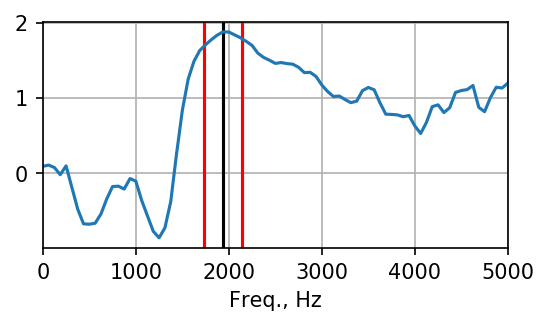

In [295]:
fig, axes = plt.subplots(1, figsize=(4,2), dpi=150, sharex=True, sharey=True)
spectra_diff = 2*(mean_spectra[0]-mean_spectra[1])/(mean_spectra[0]+mean_spectra[1])
main_freq = freq[np.argmax(np.abs(spectra_diff))]
sign = np.sign(spectra_diff[np.argmax(np.abs(spectra_diff))])
band = np.array([-1, 1])*200 + main_freq
plt.axvline(main_freq, color='k')
[plt.axvline(f, color='r') for f in band]
plt.plot(freq, spectra_diff)
plt.xlim(0, 5000)
plt.xlabel('Freq., Hz')


In [268]:
freq_slice = (freq>band[0]) & (freq<band[1])
threshold = np.exp(np.log(mean_spectra[:, freq_slice]).mean())
print(threshold)

4.977023257502992e-05


In [269]:
from time import sleep
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for label in labels:
    for k in range(500, 510):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        label_n = (spectrum[freq_slice].mean() < threshold)
        if sign < 0: label_n = ~label_n
        prediction = labels[int(label_n)]
        print('{:12s} {:12s} {}'.format(prediction, label, prediction==label))
        sd.play(x, fs)
        sleep(1.5)
        

prediction   actual       error       
cat          cat          True
cat          cat          True
cat          cat          True
dog          cat          False
dog          cat          False
cat          cat          True
cat          cat          True
cat          cat          True
dog          cat          False
cat          cat          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True


In [303]:
b, a = sg.butter(4, np.array(band)/fs*2, 'band')

print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for label in labels:
    for k in range(500, 510):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        label_n = (spectrum[freq_slice].mean() < threshold)
        if sign < 0: label_n = ~label_n
        prediction = labels[int(label_n)]
        print('{:12s} {:12s} {}'.format(prediction, label, prediction==label))
        sd.play(sg.lfilter(b, a, x), fs)
        sleep(1.5)

prediction   actual       error       
cat          cat          True
cat          cat          True
cat          cat          True
dog          cat          False
dog          cat          False
cat          cat          True
cat          cat          True
cat          cat          True
dog          cat          False
cat          cat          True
dog          dog          True
dog          dog          True
dog          dog          True
dog          dog          True


KeyboardInterrupt: 

(0, 5000)

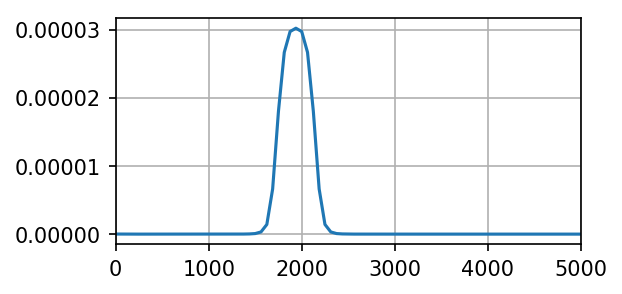

In [302]:
fig, axes = plt.subplots(1, figsize=(4,2), dpi=150, sharex=True, sharey=True)
simulated_feature = np.sin(main_freq*2*np.pi*np.arange(fs)/fs)
simulated_feature *= sg.lfilter(*sg.butter(4, 200/fs*2, 'low'), np.random.randn(fs))
sd.play(simulated_feature*5, fs)
plt.plot(*sg.welch(simulated_feature, fs))
plt.xlim(0, 5000)

In [311]:
sd.play(load_sample('dog', 500)[0], fs)